In [75]:
from pathlib import Path
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from numerize import numerize
from matplotlib import ticker

plt.style.use("ggplot")

data_wd = Path.home() / '.data' / 'predict-student-performance-from-game-play'

%matplotlib inline

# Competition Notes

The competition host is *Field Day Labs*. They aim is to make learning more fun! They also want to use data science and analytic principles to improve game-based learning through knowledge tracing

## Objective

The competition object is to use time series gameplay data to determine whether players will answer questions correctly. There are `3 question checkpoints` (levels 4, 12, & 22). At each checkpoint you will have access to all previous test data for that section.

There are `18 questions per session`. For each session & question, you are predicting whether the answer will be `correct` or not.

A secondary objective is the `Efficency prize`. I'm not currently sure what is received for that prize.

There is also a `compute constraint` of evaluation on `VMs with only 2 CPUs, 8GB RAM & no GPU`.

There was also a [`leak of the test data`](https://www.kaggle.com/competitions/predict-student-performance-from-game-play/discussion/396202)!!! They released all the test data as a result so the training data size is doubled.

In the [Greeting from the Organizers](https://www.kaggle.com/competitions/predict-student-performance-from-game-play/discussion/384801) post, they identified that the data is sourced from a game called [Jo Wilder and the Capitol Case](https://pbswisconsineducation.org/jowilder/about/). I should play the game a bit before starting. My current save code is `NOTAJERSEY`.

# Data Import

In [5]:
dtypes = dict(
    elapsed_time=np.int32, event_name='category', name='category', level=np.uint8, 
    room_coor_x=np.float32, room_coor_y=np.float32, screen_coor_x=np.float32,
    screen_coor_y=np.float32, hover_duration=np.float32, text='category',
    fqid='category', room_fqid='category', text_fqid='category',
    fullscreen='category', hq='category', music='category', level_group='category'
)
train = pd.read_csv(data_wd / 'train.csv', dtype=dtypes)

rows, columns = [numerize.numerize(x) for x in train.shape]
print(f'Training data has {rows} rows and {columns} columns')

Training data has 26.3M rows and 20 columns


In [6]:
train.head(3).T

,0,1,2
session_id,20090312431273200,20090312431273200,20090312431273200
index,0,1,2
elapsed_time,0,1323,831
event_name,cutscene_click,person_click,person_click
name,basic,basic,basic
level,0,0,0
page,NaN,NaN,NaN
room_coor_x,-413.991394,-413.991394,-413.991394
room_coor_y,-159.314682,-159.314682,-159.314682
screen_coor_x,380.0,380.0,380.0


# Feature Data

## Counts

In [8]:
print('Event Names\n' + '-' * 40)
print(', '.join(train.event_name.sort_values().unique().tolist()))

print('Room Names\n' + '-' * 40)
print(', '.join(train.room_fqid.sort_values().unique().tolist()))

print('\nCounts\n' + '-' * 40)
print(train.loc[:, ['session_id', 'event_name', 'page', 'room_fqid', 'text_fqid',]]
 .nunique()
 .map(numerize.numerize)
 .to_string()
)

Event Names
----------------------------------------
checkpoint, cutscene_click, map_click, map_hover, navigate_click, notebook_click, notification_click, object_click, object_hover, observation_click, person_click
Room Names
----------------------------------------
tunic.capitol_0.hall, tunic.capitol_1.hall, tunic.capitol_2.hall, tunic.drycleaner.frontdesk, tunic.flaghouse.entry, tunic.historicalsociety.basement, tunic.historicalsociety.cage, tunic.historicalsociety.closet, tunic.historicalsociety.closet_dirty, tunic.historicalsociety.collection, tunic.historicalsociety.collection_flag, tunic.historicalsociety.entry, tunic.historicalsociety.frontdesk, tunic.historicalsociety.stacks, tunic.humanecology.frontdesk, tunic.kohlcenter.halloffame, tunic.library.frontdesk, tunic.library.microfiche, tunic.wildlife.center

Counts
----------------------------------------
session_id    23.56K
event_name        11
page               7
room_fqid         19
text_fqid        126


It looks like we have 23 thousand `sessions`.

There are 11 different `events` with such as cutscene_click, object_hover, etc. I think we could split this up into two seperate fields, event type (i.e. click) and event target (person). We'll have to see if that's worth it later on.

Otherwise, we have 7 different `pages`, 19 `rooms` and 126 `text` boxes.

## Event Names

In [9]:
event_cnts = (train.groupby('event_name')
 .agg(
     sessions=pd.NamedAgg('session_id', 'nunique'),
     events=pd.NamedAgg('session_id', 'count')
 )
 .assign(pct_sessions=lambda x: x.sessions.div(train.session_id.nunique()))
 .sort_values('events', ascending=False)
 .applymap(numerize.numerize)
)
event_cnts

,sessions,events,pct_sessions
event_name,,,
navigate_click,23.56K,11.33M,1
person_click,23.56K,6.05M,1
cutscene_click,23.56K,2.7M,1
object_click,23.56K,2.2M,1
object_hover,21.69K,1.06M,0.92
map_hover,21.69K,945.16K,0.92
notification_click,23.56K,649K,1
notebook_click,20.89K,564.54K,0.89
map_click,23.56K,517.24K,1


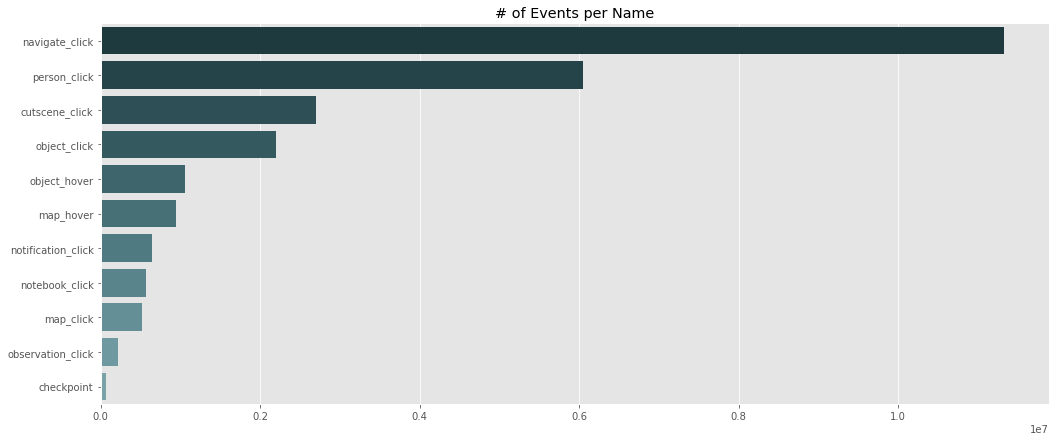

In [43]:
fig, ax = plt.subplots(figsize=(17, 7))
sns.countplot(data=train, y='event_name', ax=ax, order=event_cnts.index, palette='ch:start=2.5,dark=.6,light=.2,rot=0')
ax.set(xlabel='', ylabel='', title='# of Events per Name')
plt.show()

Some interesting stuff here!

`Navigation clicks` were the most common with over 11 million! Those aren't probably super important though because it's the player moving around. But may I'm wrong and they are important!

`Checkpoints` were the list common with only ~70 thousand. That make sense because they're less common events.

My guess is that some of the middle groups like `observations clicks`, `object hovers` and `notebook clicks` could be good proxies for engagement. If a player is engaging more in the optional events like these, they might be more likely to get the questions right!

## Rooms

From the above, we know that all the rooms start with "tunic". Let's validate that and then emove that since it's pretty unnecessary!

In [11]:
assert (train.room_fqid.str.split('.', expand=True)[0] == 'tunic').all()

Cool! Now that's validated, let's remove "tunic" we can split our room fqid into two separate components.

The second section looks like it's the `building` that the room is located in, while the third section is the `room` with that building. 

In [26]:
train['building'] = pd.Categorical(train.room_fqid.str.split('.', expand=True)[1])
train['room'] = pd.Categorical(train.room_fqid.str.split('.', expand=True)[2])

(pd.DataFrame(train.groupby(['building', 'room'], sort=True, observed=True).size().map(numerize.numerize))
 .rename(columns={0:'cnt_events'})
)

cnt_events
building          room                      
historicalsociety closet             857.27K
                  basement             1.17M
                  entry                3.62M
                  collection          957.4K
                  stacks               1.79M
                  closet_dirty         1.57M
                  frontdesk            1.94M
                  cage                 2.35M
                  collection_flag     452.4K
kohlcenter        halloffame            1.1M
capitol_0         hall               416.47K
humanecology      frontdesk            1.33M
drycleaner        frontdesk          981.45K
library           frontdesk            2.15M
                  microfiche         995.67K
capitol_1         hall               445.57K
wildlife          center               3.01M
flaghouse         entry              833.79K
capitol_2         hall                326.1K

# Label Data (Questions) 

In [29]:
labels = (pd.read_csv(data_wd / 'train_labels.csv')
          .rename(columns=dict(session_id='sq_id')))
assert labels.sq_id.is_unique
labels.loc[:, ['session_id', 'question_id']] = labels.sq_id.str.split('_', expand=True).values
labels = (labels.set_index('sq_id')
          .assign(question_id=lambda x: x.question_id.str.replace('q', '').astype(int))
         )
rows, columns = [numerize.numerize(x) for x in labels.shape]
print(f'Training labels has {rows} rows and {columns} columns\n\n')

labels.head()

Training labels has 424.12K rows and 3 columns




,correct,session_id,question_id
sq_id,,,
20090312431273200_q1,1,20090312431273200,1
20090312433251036_q1,0,20090312433251036,1
20090312455206810_q1,1,20090312455206810,1
20090313091715820_q1,0,20090313091715820,1
20090313571836404_q1,1,20090313571836404,1


We can see from that assertion that every session/question is unique. Basically that a session can't attempt the same question multiple times.

We have over 400 thousand sessions. Are all questions equally challenging to answer or is there variance across them?

In [50]:
questions = (labels.groupby(['question_id'])
 .agg(
     cnt_correct=pd.NamedAgg('correct', 'sum'),
     total_questions=pd.NamedAgg('correct', 'count')
 )
 .assign(pct_correct=lambda x: x.cnt_correct.div(x.total_questions))
)
questions.applymap(numerize.numerize)

,cnt_correct,total_questions,pct_correct
question_id,,,
1,17.14K,23.56K,0.73
2,23.06K,23.56K,0.98
3,22.01K,23.56K,0.93
4,18.81K,23.56K,0.8
5,12.92K,23.56K,0.55
6,18.28K,23.56K,0.78
7,17.34K,23.56K,0.74
8,14.54K,23.56K,0.62
9,17.35K,23.56K,0.74


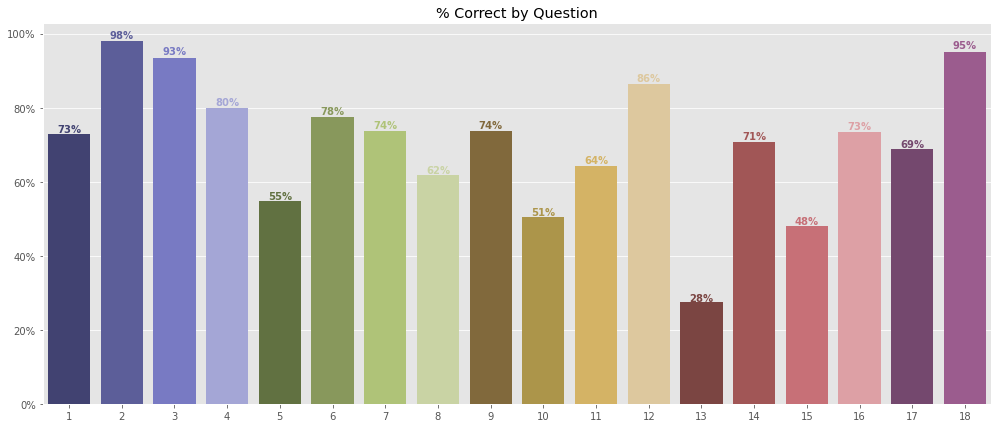

In [77]:
fig, ax = plt.subplots(figsize=(17, 7))
sns.barplot(data=questions.reset_index(), x='question_id', y='pct_correct', ax=ax, 
            palette='tab20b')
ax.set(xlabel='', ylabel='', title='% Correct by Question')

for p in ax.patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + p.get_height() * 1.01
    value = f'{p.get_height():,.0%}'
    ax.text(x, y, value, color=p.get_facecolor(), fontweight='semibold', ha='center')

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0%}"))

plt.show()

Woah! Question 13 must of been a tough one!!!

We can see there is a good amount of variation between questions!